# Prewitt - Thershold

In [53]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from collections import Counter

In [54]:
# fungsi untuk crop citra ke ukuran 1 banding 1
def crop_to_1by1(citra_input):
    tinggi, panjang = citra_input.shape[:2]

    if(panjang == tinggi):
        print(f"{tinggi} == {panjang}\n tidak perlu crop ke 1:1")
        return citra_input

    if panjang < tinggi:
        terpendek = panjang
    elif panjang > tinggi:
        terpendek = tinggi

    hasil = np.zeros((terpendek, terpendek), dtype=citra_input.dtype)

    if panjang > tinggi:
        offset = (panjang - terpendek) // 2
        for i in range(terpendek):
            for j in range(terpendek):
                hasil[i, j] = citra_input[i, j + offset]
    else:
        offset = (tinggi - terpendek) // 2
        for i in range(terpendek):
            for j in range(terpendek):
                hasil[i, j] = citra_input[i + offset, j]

    return hasil

In [55]:
# fungsi untuk resize citra agar semuanya memiliki ukuran yang sama
def resize(citra_input, tinggi_baru, panjang_baru):
    tinggi, panjang = citra_input.shape[:2]
    resized_citra = np.zeros((tinggi_baru, panjang_baru), dtype=citra_input.dtype)

    y_ratio = tinggi / tinggi_baru
    x_ratio = panjang / panjang_baru

    for i in range(tinggi_baru):
        for j in range(panjang_baru):
            src_y = int(i * y_ratio)
            src_x = int(j * x_ratio)
            resized_citra[i, j] = citra_input[src_y, src_x]

    return resized_citra

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [56]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = crop_to_1by1(img)
        img = resize(img, 140, 140)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

225 == 225
 tidak perlu crop ke 1:1
225 == 225
 tidak perlu crop ke 1:1
225 == 225
 tidak perlu crop ke 1:1
225 == 225
 tidak perlu crop ke 1:1
225 == 225
 tidak perlu crop ke 1:1


In [57]:
print(type(img))           # Cek apakah ini NumPy array
print(img.dtype)           # Cek tipe data elemen (misal: uint8, float32, dll)
print(img.shape)           # Ukuran array (dimensi)

<class 'numpy.ndarray'>
uint8
(140, 140)


## Data Understanding

In [58]:
# -----------------------------
# 1. Menampilkan Jumlah Data
print("Jumlah total gambar:", len(data))
print("Jumlah kelas:", len(np.unique(labels)))
print("Distribusi per kelas:", Counter(labels))

Jumlah total gambar: 156
Jumlah kelas: 2
Distribusi per kelas: Counter({np.str_('Clean'): 81, np.str_('Dirty'): 75})


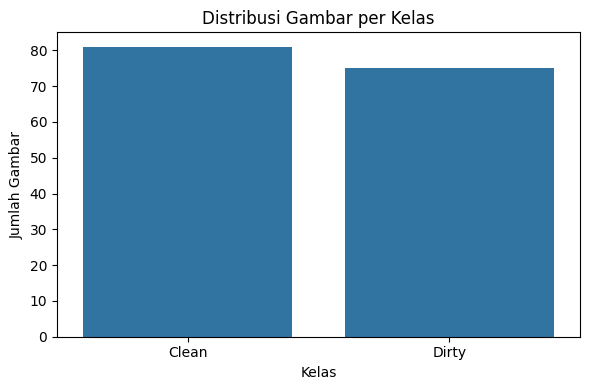

In [59]:
# -----------------------------
# 2. Visualisasi Distribusi Data
label_df = pd.DataFrame({'Label': labels})
plt.figure(figsize=(6,4))
sns.countplot(x='Label', data=label_df)
plt.title("Distribusi Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.tight_layout()
plt.show()

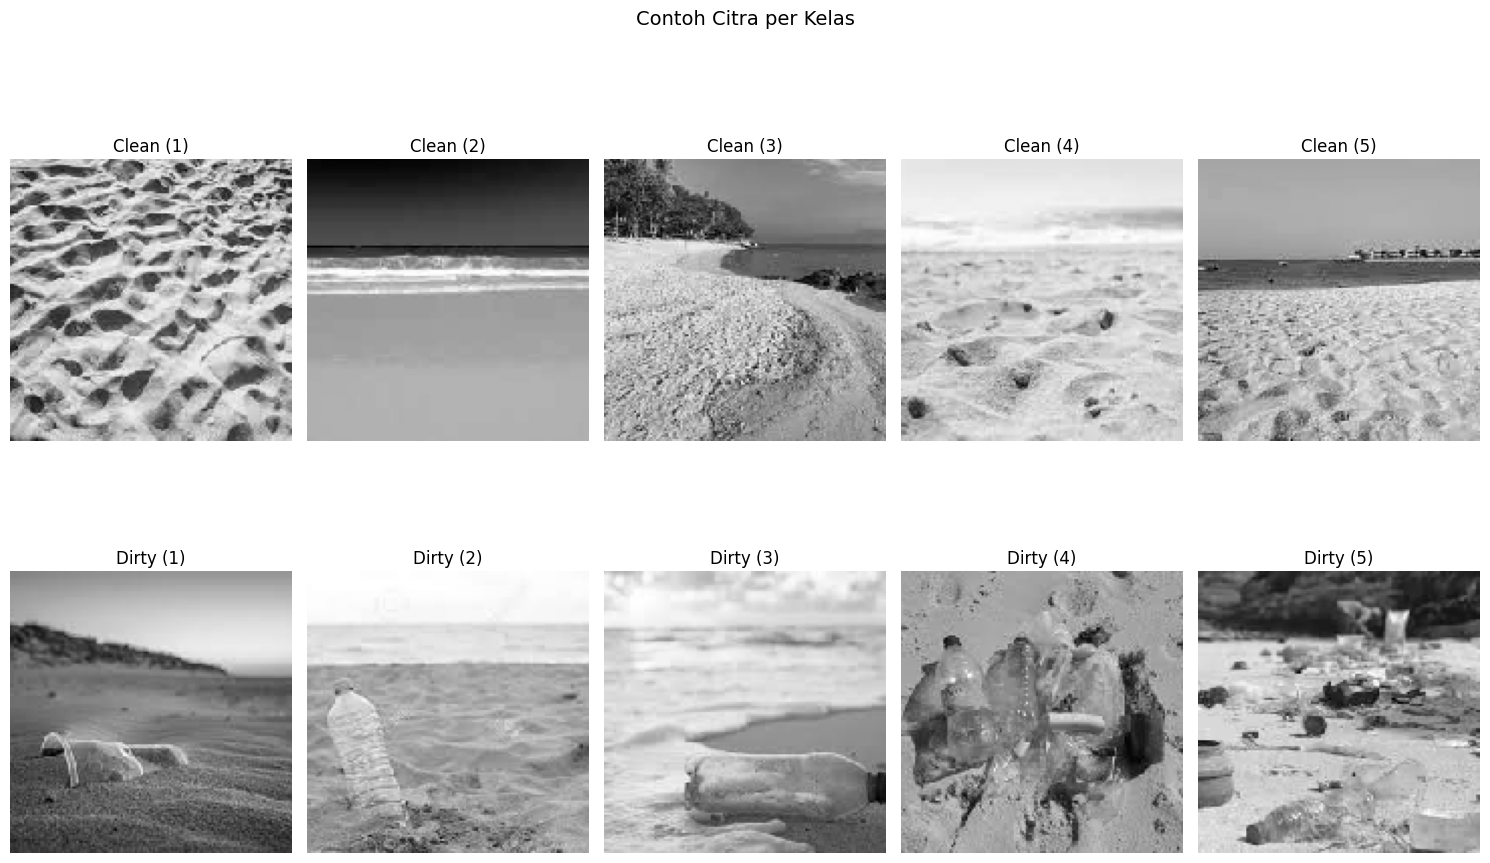

In [60]:
# -----------------------------
# 3. Menampilkan Sample Gambar per Kelas
unique_labels = np.unique(labels)
plt.figure(figsize=(15, 10))  # disesuaikan agar muat 5 kolom

for i, label in enumerate(unique_labels):
    idxs = np.where(labels == label)[0][:5]  # ambil 5 indeks pertama untuk label ini
    for j, idx in enumerate(idxs):
        plt.subplot(len(unique_labels), 5, i*5 + j + 1)
        plt.imshow(data[idx], cmap='gray')
        plt.title(f"{label} ({j+1})")
        plt.axis('off')

plt.suptitle("Contoh Citra per Kelas", fontsize=14)
plt.tight_layout()
plt.show()

In [61]:
# label_target = 'Dirty'  # Ganti ke 'Clean' jika ingin label lain

# # Ambil indeks yang sesuai dengan label_target
# idxs = np.where(labels == label_target)[0]
# total_images = len(idxs)

# cols = 5  # Jumlah kolom
# rows = (total_images + cols - 1) // cols  # Hitung jumlah baris yang dibutuhkan

# plt.figure(figsize=(15, 3 * rows))  # Atur ukuran fig sesuai jumlah baris

# for i, idx in enumerate(idxs):
#     plt.subplot(rows, cols, i + 1)
#     plt.imshow(data[idx], cmap='gray')
#     plt.title(file_name[idx])  # Gunakan nama file sebagai judul
#     plt.axis('off')

# plt.tight_layout(rect=[0, 0, 1, 0.978])  # Menyisakan 2.2% ruang di atas untuk suptitle
# plt.suptitle(f"Seluruh Citra Label '{label_target}' sebelum Preprocessing", fontsize=14)
# plt.show()

In [62]:
# label_target = 'Clean'

# # Ambil indeks yang sesuai dengan label_target
# idxs = np.where(labels == label_target)[0]
# total_images = len(idxs)

# cols = 5  # Jumlah kolom
# rows = (total_images + cols - 1) // cols  # Hitung jumlah baris yang dibutuhkan

# plt.figure(figsize=(15, 3 * rows))  # Atur ukuran fig sesuai jumlah baris

# for i, idx in enumerate(idxs):
#     plt.subplot(rows, cols, i + 1)
#     plt.imshow(data[idx], cmap='gray')
#     plt.title(file_name[idx])  # Gunakan nama file sebagai judul
#     plt.axis('off')

# plt.tight_layout(rect=[0, 0, 1, 0.978])  # Menyisakan 2.2% ruang di atas untuk suptitle
# plt.suptitle(f"Seluruh Citra Label '{label_target}' sebelum Preprocessing", fontsize=14)
# plt.show()

## Data Augmentation

### Define Augmentation Function


In [63]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	pass

In [64]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  156
Data setelah augmentasi:  0


## Data Preparation

### Define Preprocessing Function


In [65]:
# edge padding 1 px ke semua sisi
def edge_padding_1px(input_citra):
    tinggi_input, panjang_input = input_citra.shape[:2]

    tinggi_output = tinggi_input+2
    panjang_output = panjang_input+2

    output = np.zeros((tinggi_output, panjang_output), dtype=input_citra.dtype)

    # Salin bagian tengah
    output[1:-1, 1:-1] = input_citra

    # Padding baris atas dan bawah
    output[0, 1:-1] = input_citra[0, :]
    output[-1, 1:-1] = input_citra[-1, :]

    # Padding kolom kiri dan kanan
    output[1:-1, 0] = input_citra[:, 0]
    output[1:-1, -1] = input_citra[:, -1]

    # Sudut-sudut
    output[0, 0] = input_citra[0, 0]
    output[0, -1] = input_citra[0, -1]
    output[-1, 0] = input_citra[-1, 0]
    output[-1, -1] = input_citra[-1, -1]

    return output

# definisi kernel prewitt
kernel_prewitt_Gx = np.array([[-1, 0, +1],
                              [-1, 0, +1],
                              [-1, 0, +1]])

kernel_prewitt_Gy = np.array([[+1, +1, +1],
                              [ 0,  0,  0],
                              [-1, -1, -1]])

# untuk geser kernel di atas citra
def konvolusi_3x3(citra_input, jenis_kernel): # untuk padded 1px
    tinggi, panjang = citra_input.shape[:2]

    tinggi_hasil = tinggi-2 # kurangin padding tadi
    panjang_hasil = panjang-2

    hasil = np.zeros((tinggi_hasil, panjang_hasil), dtype=np.float32)

    for i in range(0, tinggi_hasil):
        for j in range(0, panjang_hasil):
            sum_jendela = 0
            for k in range(i, i+3): # 3x3
                for l in range(j, j+3):
                    sum_jendela += float(citra_input[k, l]) * jenis_kernel[k-i, l-j]
            hasil[i, j] = sum_jendela 

    return hasil

# untuk menghitung G
def magnitudo_gradien(Gx, Gy):
    Gx = Gx.astype(np.float32)
    Gy = Gy.astype(np.float32)

    tinggi, panjang = Gx.shape[:2]
    G = np.zeros((tinggi, panjang), dtype=np.float32)

    for i in range(tinggi):
        for j in range(panjang):
            G[i, j] = (Gx[i, j]**2 + Gy[i, j]**2)**0.5

    return G

# untuk deteksi tepi
def edge_detection(img, kernel_Gx, kernel_Gy):
    img_padded = edge_padding_1px(img) # tambahkan padding

    Gx = konvolusi_3x3(img_padded, kernel_Gx)
    Gy = konvolusi_3x3(img_padded, kernel_Gy)
    G = magnitudo_gradien(Gx, Gy)

    return G

# untuk normalisasi dan mengembalikan float32 ke uint8
def G_normalized(G):
    G_max = G.max()
    if G_max == 0:
        return np.zeros_like(G, dtype=np.uint8)
    return ((G / G_max) * 255).astype(np.uint8)

In [66]:
# untuk thresholding, dengan ambang batas n
def thresholding(image, n):

    image = np.array(image)
    result = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] >= n:
                result[i][j] = 255
            else:
                result[i][j] = 0

    return result

In [67]:
def prepro3():
    pass

def prepro4():
    pass

### Preprocessing

In [68]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = [] # variabel ini digunakan untuk menyimpan img hasil preprocessing
for i in range(len(data)): # Loop through each image and do preprocessing
	img = data[i] # ambil img yang akan dipreprocessing dari array data
	img = edge_detection(img, kernel_prewitt_Gx, kernel_prewitt_Gy) # deteksi tepi
	img = G_normalized(img) # kembalikan float32 ke uint8
	img = thresholding(img, 100) # proses lagi img dengan thresholding

	dataPreprocessed.append(img) # tambah dataPreprocessed dengan img yang tadi telah diproses

dataPreprocessed = np.array(dataPreprocessed) # ubah jadi numpy array

In [69]:
## buat ngecek tipe datanya (siapa tau berubah)
print(type(img))           # Cek apakah ini NumPy array
print(img.dtype)           # Cek tipe data elemen (misal: uint8, float32, dll)
print(img.shape)           # Ukuran array (dimensi)

<class 'numpy.ndarray'>
uint8
(140, 140)


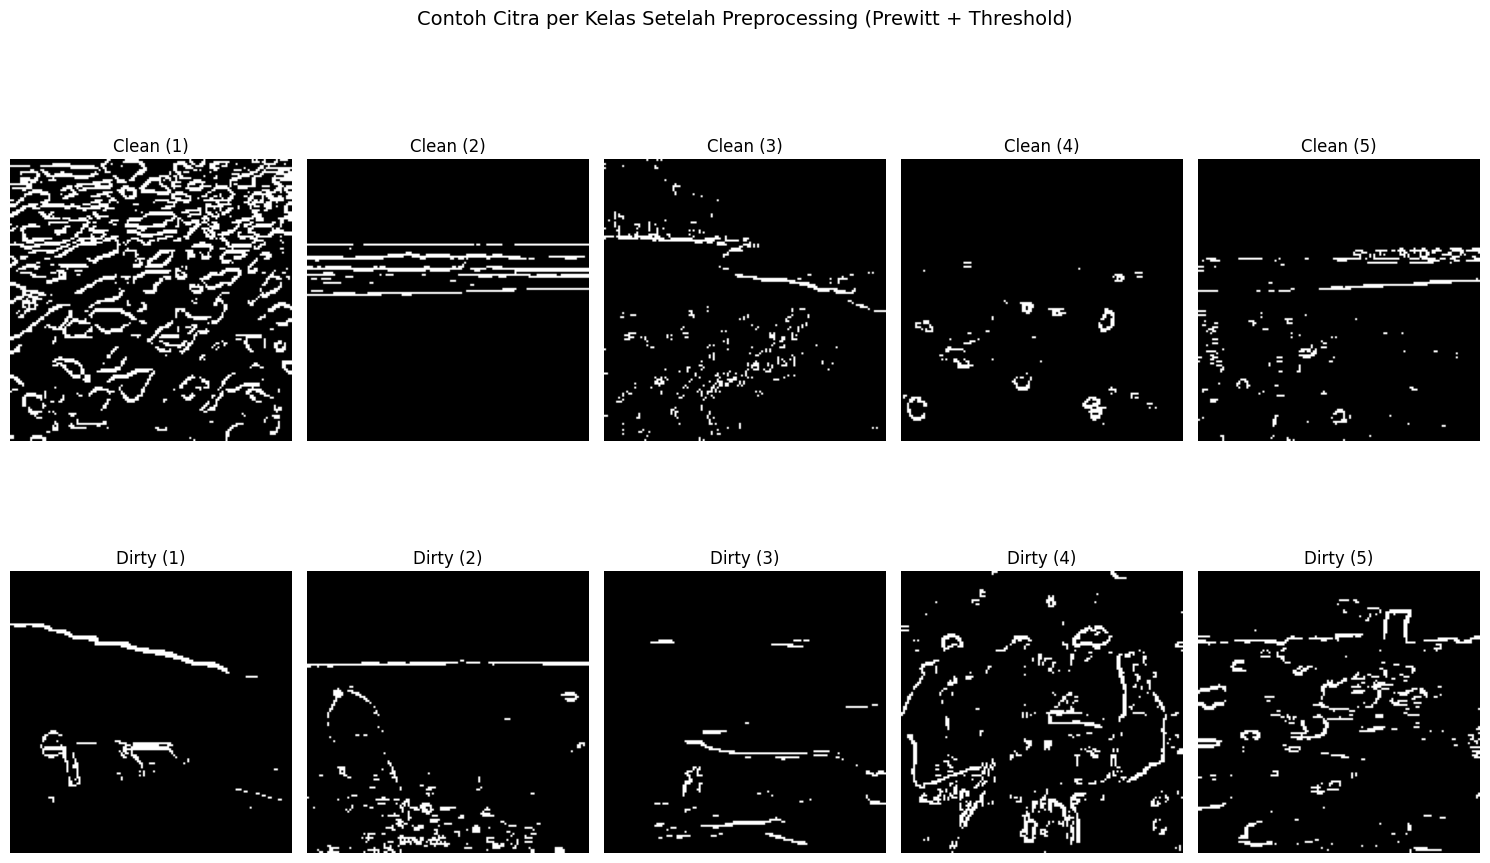

In [70]:
# -----------------------------
# 3. Menampilkan Sample Gambar per Kelas
unique_labels = np.unique(labels)
plt.figure(figsize=(15, 10))  # disesuaikan agar muat 5 kolom

for i, label in enumerate(unique_labels):
    idxs = np.where(labels == label)[0][:5]  # ambil 5 indeks pertama untuk label ini
    for j, idx in enumerate(idxs):
        plt.subplot(len(unique_labels), 5, i*5 + j + 1)
        plt.imshow(dataPreprocessed[idx], cmap='gray')
        plt.title(f"{label} ({j+1})")
        plt.axis('off')

plt.suptitle("Contoh Citra per Kelas Setelah Preprocessing (Prewitt + Threshold)", fontsize=14)
plt.tight_layout()
plt.show()

In [71]:
# label_target = 'Dirty'  # Ganti ke 'Clean' jika ingin label lain

# # Ambil indeks yang sesuai dengan label_target
# idxs = np.where(labels == label_target)[0]
# total_images = len(idxs)

# cols = 5  # Jumlah kolom
# rows = (total_images + cols - 1) // cols  # Hitung jumlah baris yang dibutuhkan

# plt.figure(figsize=(15, 3 * rows))  # Atur ukuran fig sesuai jumlah baris

# for i, idx in enumerate(idxs):
#     plt.subplot(rows, cols, i + 1)
#     plt.imshow(dataPreprocessed[idx], cmap='gray')
#     plt.title(file_name[idx])  # Gunakan nama file sebagai judul
#     plt.axis('off')

# plt.tight_layout(rect=[0, 0, 1, 0.978])  # Menyisakan 2.2% ruang di atas untuk suptitle
# plt.suptitle(f"Seluruh Citra Label '{label_target}' setelah Preprocessing (Prewitt + Threshold)", fontsize=14)
# plt.show()

In [72]:
# label_target = 'Clean'

# # Ambil indeks yang sesuai dengan label_target
# idxs = np.where(labels == label_target)[0]
# total_images = len(idxs)

# cols = 5  # Jumlah kolom
# rows = (total_images + cols - 1) // cols  # Hitung jumlah baris yang dibutuhkan

# plt.figure(figsize=(15, 3 * rows))  # Atur ukuran fig sesuai jumlah baris

# for i, idx in enumerate(idxs):
#     plt.subplot(rows, cols, i + 1)
#     plt.imshow(dataPreprocessed[idx], cmap='gray')
#     plt.title(file_name[idx])  # Gunakan nama file sebagai judul
#     plt.axis('off')

# plt.tight_layout(rect=[0, 0, 1, 0.978])  # Menyisakan 2.2% ruang di atas untuk suptitle
# plt.suptitle(f"Seluruh Citra Label '{label_target}' setelah Preprocessing (Prewitt + Threshold)", fontsize=14)
# plt.show()

### Feature Extraction

In [73]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [74]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [75]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [76]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [77]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [78]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [79]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [80]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [81]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [82]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [83]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [84]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [85]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [86]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [87]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [88]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [89]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [90]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,1.jpg,Clean,8644.382066,17349.199058,14936.369476,14939.494591,0.867063,0.733196,0.770302,0.770254,...,0.476040,0.475810,0.733890,0.676131,0.689957,0.689790,0.615936,0.231598,0.338075,0.338325
1,10.jpg,Clean,431.049589,4331.410124,4317.178828,4304.486051,0.993371,0.933390,0.933608,0.933804,...,0.846817,0.846971,0.950169,0.920115,0.920226,0.920310,0.926828,0.269719,0.272001,0.274258
2,11.jpg,Clean,2723.297790,3745.811552,3227.859712,3712.156462,0.958120,0.942395,0.950360,0.942913,...,0.878524,0.871788,0.941125,0.933450,0.937296,0.933696,0.435248,0.225556,0.331895,0.232515
3,12.jpg,Clean,969.026208,1534.672118,1289.807297,1548.134155,0.985098,0.976399,0.980165,0.976192,...,0.942661,0.938595,0.973357,0.968913,0.970907,0.968811,0.606764,0.381582,0.476589,0.376157
4,13.jpg,Clean,1383.368448,3254.447234,3097.542395,3207.330107,0.978726,0.949952,0.952365,0.950676,...,0.891356,0.890069,0.957253,0.943089,0.944117,0.943435,0.661474,0.206063,0.247175,0.217557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,73.jpg,Dirty,2596.321942,3981.397184,3274.640288,3846.776823,0.960073,0.938772,0.949641,0.940842,...,0.857917,0.849579,0.931222,0.920738,0.926238,0.921726,0.577441,0.353871,0.465734,0.375718
152,74.jpg,Dirty,1390.051387,3177.040526,3060.786228,3129.923399,0.978623,0.951142,0.952930,0.951867,...,0.890381,0.889742,0.956600,0.942914,0.943600,0.943261,0.665964,0.241809,0.273195,0.253053
153,75.jpg,Dirty,1617.271326,4536.706175,4437.471737,4624.209409,0.975129,0.930232,0.931759,0.928887,...,0.839105,0.836436,0.937496,0.915201,0.916027,0.914569,0.743190,0.284474,0.298704,0.270673
154,8.jpg,Dirty,5062.326567,7740.670773,6659.549075,7693.553646,0.922149,0.880960,0.897586,0.881685,...,0.748916,0.735959,0.876811,0.857559,0.865400,0.857881,0.511630,0.254699,0.356516,0.259236


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

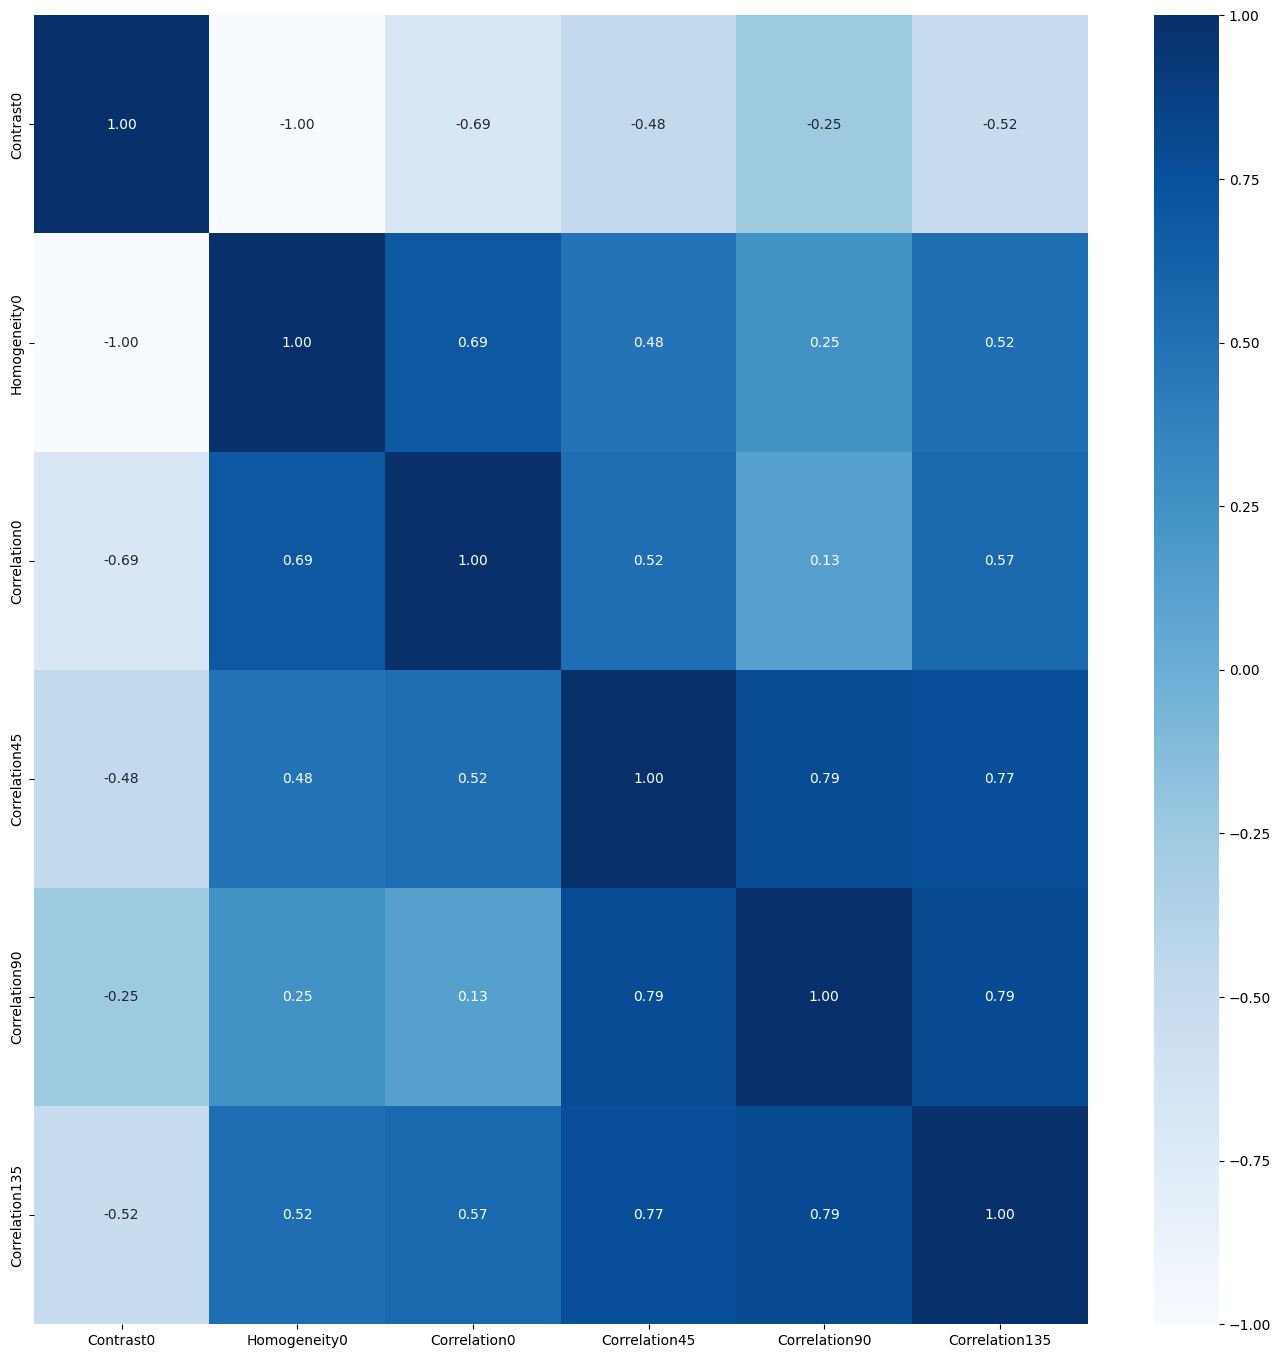

In [91]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [92]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(124, 6)
(32, 6)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [93]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [94]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [95]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       Clean       0.94      0.92      0.93        65
       Dirty       0.92      0.93      0.92        59

    accuracy                           0.93       124
   macro avg       0.93      0.93      0.93       124
weighted avg       0.93      0.93      0.93       124

[[60  5]
 [ 4 55]]
Accuracy: 0.9274193548387096

------Testing Set------
              precision    recall  f1-score   support

       Clean       0.69      0.56      0.62        16
       Dirty       0.63      0.75      0.69        16

    accuracy                           0.66        32
   macro avg       0.66      0.66      0.65        32
weighted avg       0.66      0.66      0.65        32

[[ 9  7]
 [ 4 12]]
Accuracy: 0.65625


### Train SVM Classifier

In [96]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       Clean       0.81      0.80      0.81        65
       Dirty       0.78      0.80      0.79        59

    accuracy                           0.80       124
   macro avg       0.80      0.80      0.80       124
weighted avg       0.80      0.80      0.80       124

[[52 13]
 [12 47]]
Accuracy: 0.7983870967741935

------Testing Set------
              precision    recall  f1-score   support

       Clean       0.63      0.75      0.69        16
       Dirty       0.69      0.56      0.62        16

    accuracy                           0.66        32
   macro avg       0.66      0.66      0.65        32
weighted avg       0.66      0.66      0.65        32

[[12  4]
 [ 7  9]]
Accuracy: 0.65625


### Train KNN Classifier

In [97]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       Clean       0.83      0.77      0.80        65
       Dirty       0.77      0.83      0.80        59

    accuracy                           0.80       124
   macro avg       0.80      0.80      0.80       124
weighted avg       0.80      0.80      0.80       124

[[50 15]
 [10 49]]
Accuracy: 0.7983870967741935

------Testing Set------
              precision    recall  f1-score   support

       Clean       0.64      0.56      0.60        16
       Dirty       0.61      0.69      0.65        16

    accuracy                           0.62        32
   macro avg       0.63      0.62      0.62        32
weighted avg       0.63      0.62      0.62        32

[[ 9  7]
 [ 5 11]]
Accuracy: 0.625


## Evaluation With Confusion Matrix

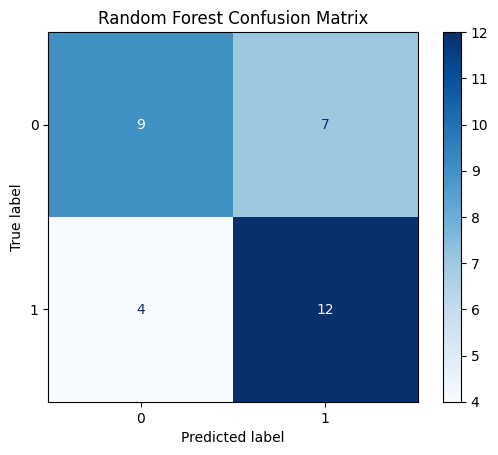

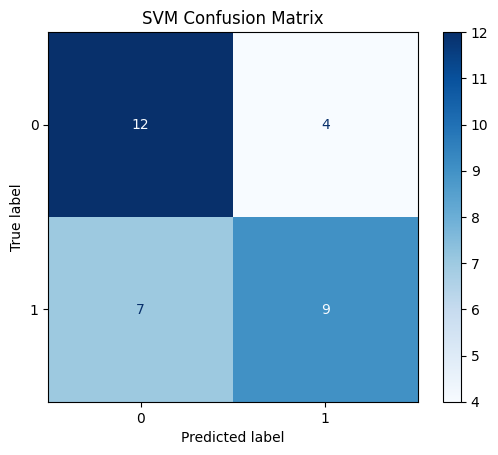

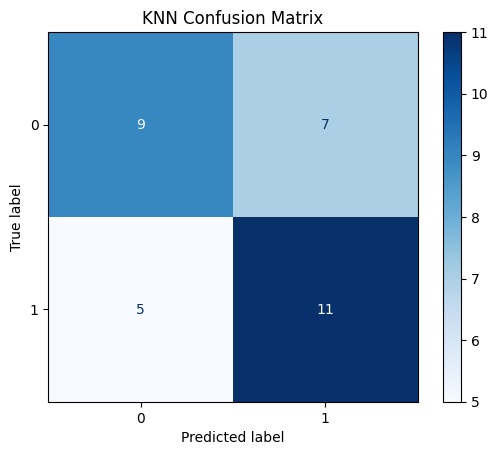

In [98]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")